# Mini-projet n°2 - Conditional VAEs

L'objectif de ce projet est de définir et entraîner un Conditional VAE (CVAE). Nous allons tout d'abord définir ce qu'est un CVAE et la différence avec un VAE, puis définir et entraîner un CVAE sur le dataset Fashin-MNIST.

## Définition d'un CVAE

### Définition d'un VAE

Un Variational AutoEncoder (VAE) est un autoencoder qui cherche à apprendre la distribution des données $x$, en introduisant des variables latentes $z$. produit une distribution de probabilité dans l'espace latent. La partie encodeur va apprendre $q(z|x)$, soit la distribution de $z$, la forme dans l'espace latent, en sachant $x$, la donnée d'entrée. En réalité, on va plutôt poser $z=\mu(x) + \sigma(x) \epsilon$, avec $\epsilon \sim \mathcal{N}(0,1)$. Ainsi, l'encodeur apprendra plutôt l'espérance $\mu$ et le log de l'écart-type $\log(\sigma)$. A l'inverse, la partie décodeur va apprendre $p(x|z)$, soit la distriubtion de la donnée d'entrée $x$ en connaissant sa place dans l'espace. 

La fonction perte utilisée pour un VAE est :
$$Loss =  L(x, x') + \sum_{j=1}^{m} KL( q(z_j | x) \Vert \, p(z_j))$$

avec $L$ une fonction perte de reconstruction telle que la MSE ou BCE, qui va permettre au VAE de recréer des données de sorties proches des données initiales; et $KL : (f, f') \to KL(f, f')$ la divergence de Kullback-Leibler, qui va forcer l'espace latent à suivre une distribution donnée $p(z)$. On suppose en général que $p(z) \sim \mathcal{N}(0,1)$.

On peut ensuite échantillonner un point de la distribution de probabilité de l'espace latent afin de générer de nouvelles données grâce au décodeur. 

Voici une image issue du site https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html#cvae pour mieux visualiser.

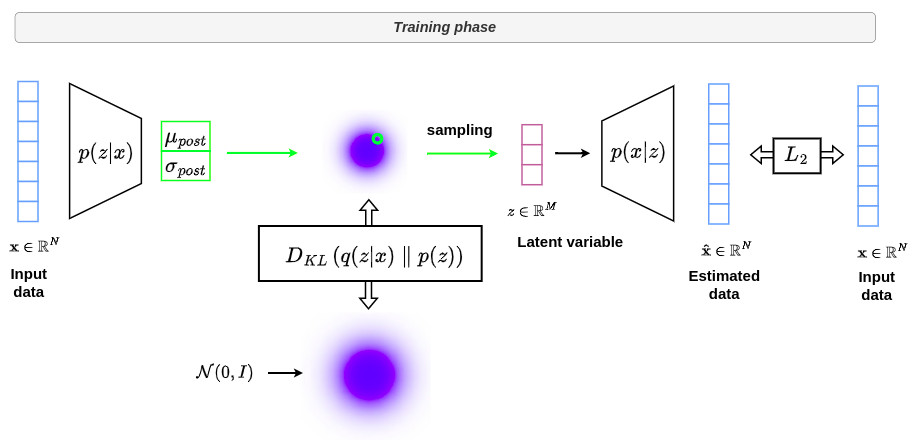

### Définition d'un CVAE

Le CVAE est une extension du VAE du point de vue de la structure. La différence réside dans le fait qu'on ajoute un deuxième conditionnement, $y$ qui donne des informations sur le contexte de la donnée d'entrée $x$. Par exemple, $x$ peut être une image et $y$ son label. D'une part, l'encodeur va apprendre $q(z|x,y)$, avec $z$ la représentation de $x$ dans l'espace latent. De la même manière qu'un VAE, encore une fois l'encodeur va apprendre $\mu(x,y)$ et $\sigma(x,y)$ de la distribution. De l'autre part, le décodeur va apprendre $p(x|z,y)$ : on trouve donc à la fois la représentation dans l'espace latent $z$ mais aussi le label $y$ dans l'entrée du décodeur. 

La fonction perte utilisée pour un CVAE est :
A CONTINUER
https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf

Après avoir entraîné le modèle, on peut créer de nouvelles données d'une classe spécifique en donnant $y$ le label de la donnée que l'on souhaite créer, et en échantillonnant un point de la distribution de l'espace latent (supposée normale). Alors que pour un VAE l'espace latent va décrire les différences entre les classes, l'espace latent d'un CVAE va décrire la différence entre les objets d'une même classe. Ainsi, en donnant un même échantillon de l'espace latent $z$ mais un label $y$ différent, le décodeur va fournir des images des différentes classes demandées, mais avec un même style car $z$ était similaire. 

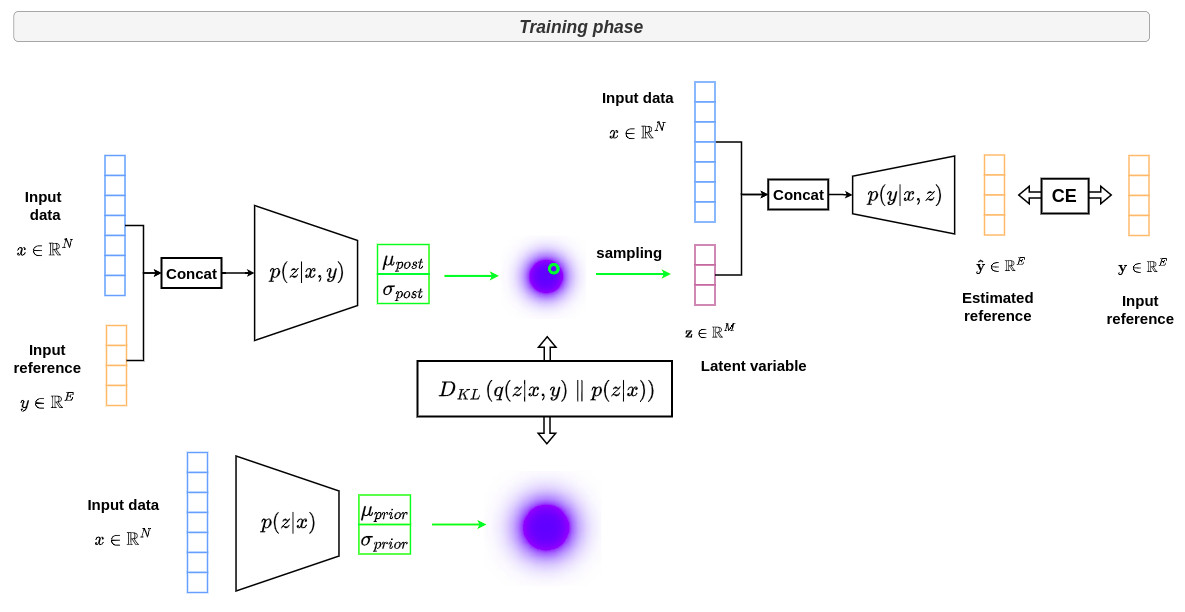

## Création du CVAE

In [1]:
# Maths
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Deep Learning
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Importation des données

In [4]:
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(
    root="./Fashion_MNIST",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./Fashion_MNIST",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
img, label = train_dataset[0]
print("Image shape :", img.shape)

classes = {0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4: 'Coat',
    5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot' }

print(classes)


Image shape : torch.Size([1, 28, 28])
{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}


Le jeu de données Fashion MNIST comporte 70 000 images labellisées de taille $28 \times 28$.
Il y a 10 classes différentes, qui représentes différentes vêtements : 
- T-shirt 
- Pantlons
- Pull
- Robes
- Manteau
- Sandales
- Chemises
- Chaussures / baskets
- Sac
- Bottes

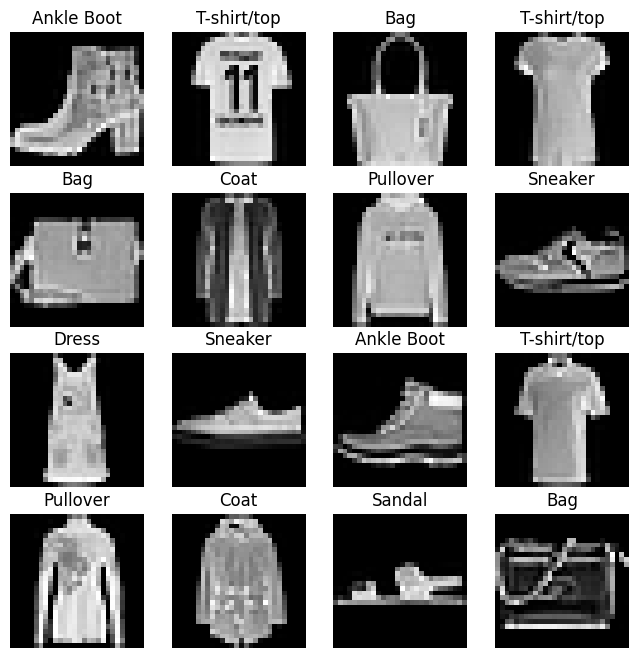

In [6]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(classes[labels[i].item()])
    #plt.title(labels[i].item())
    plt.axis("off")
plt.show()


In [7]:
labels = [label for _, label in train_dataset]
count = Counter(labels)
print("Nombre d'images dans chaque classes dans le jeu d'apprentissage :")
for idx, c in count.items():
    print(f"- {classes[idx]} : {c}")

Nombre d'images dans chaque classes dans le jeu d'apprentissage :
- Ankle Boot : 6000
- T-shirt/top : 6000
- Dress : 6000
- Pullover : 6000
- Sneaker : 6000
- Sandal : 6000
- Trouser : 6000
- Shirt : 6000
- Coat : 6000
- Bag : 6000


In [8]:
labels = [label for _, label in test_dataset]
count = Counter(labels)
print("Nombre d'images dans chaque classes dans le jeu de test :")
for idx, c in count.items():
    print(f"- {classes[idx]} : {c}")

Nombre d'images dans chaque classes dans le jeu de test :
- Ankle Boot : 1000
- Pullover : 1000
- Trouser : 1000
- Shirt : 1000
- Coat : 1000
- Sandal : 1000
- Sneaker : 1000
- Dress : 1000
- Bag : 1000
- T-shirt/top : 1000


### Défintion du CVAE

In [15]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=128, num_classes=10, embedding_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.flatten_size = 128 * 4 * 4

        # Conditional embedding
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # Latent space (with concatenated condition)
        self.fc_mu = nn.Linear(self.flatten_size + embedding_dim, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size + embedding_dim, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + embedding_dim, 4 * 4 * 128)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        x = self.encoder(x)
        c = self.label_embedding(c)
        
        # Concatenate condition with encoded input
        x = torch.cat([x, c], dim=1)

        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        c = self.label_embedding(c)
        # Concatenate condition with latent vector
        z = torch.cat([z, c], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 4, 4)
        return self.decoder(z)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.sample(mu, log_var)
        return self.decode(z, c), mu, log_var

In [13]:
def loss_function(recon_x, x, mu, logvar, beta = 1) :
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD

The CVAE encoder consists of 3 convolutional layers each followed by a ReLU non-linearity. The output of the encoder is then flattened. The class number is then passed through an embedding layer and added to the encoder output. The reparameterization trick is then used with 2 linear layers to obtain a μ and σ in the latent space. Once sampled, the output of the reparameterized latent space is passed to the decoder now concatenated with the class number embedding layer output. The decoder consists of 3 transposed convolutional layers. The first two contain a ReLU non-linearity with the last layer containing a sigmoid non-linearity. The output of the decoder is a 28×28 generated image.

The other model architecture follows the same approach but with adding the conditional input instead of concatenating. A major question was if adding or concatenating will lead to better reconstruction or generation results.

on choisit concat plutôt que add car meilleurs résultats 
on choisit embedding plutôt que one hot 

## Entraînement du CVAE

In [14]:
# Paramètres
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1

In [106]:
cvae1 = ConditionalVAE(latent_dim=latent_dim, num_classes=10)
cvae1.to(device)
optimizer = optim.Adam(cvae1.parameters(), lr=learning_rate)


for epoch in range(1, epochs + 1):
    cvae1.train()
    running_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae1(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() 
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

Epoch 1, Training loss: 286.6802
Epoch 2, Training loss: 258.6891
Epoch 3, Training loss: 256.2993
Epoch 4, Training loss: 255.1984
Epoch 5, Training loss: 254.4704
Epoch 6, Training loss: 253.9884
Epoch 7, Training loss: 253.5850
Epoch 8, Training loss: 253.2416
Epoch 9, Training loss: 252.9997
Epoch 10, Training loss: 252.7624
Epoch 11, Training loss: 252.6111
Epoch 12, Training loss: 252.3463
Epoch 13, Training loss: 252.2085
Epoch 14, Training loss: 252.0967
Epoch 15, Training loss: 251.8704
Epoch 16, Training loss: 251.8086
Epoch 17, Training loss: 251.7327
Epoch 18, Training loss: 251.6072
Epoch 19, Training loss: 251.5002
Epoch 20, Training loss: 251.4179
Epoch 21, Training loss: 251.3281
Epoch 22, Training loss: 251.2324
Epoch 23, Training loss: 251.1525
Epoch 24, Training loss: 251.0224
Epoch 25, Training loss: 250.9823
Epoch 26, Training loss: 250.9312
Epoch 27, Training loss: 250.8681
Epoch 28, Training loss: 250.7709
Epoch 29, Training loss: 250.7076
Epoch 30, Training loss

In [107]:
def comparison_images(im1, title1, im2, title2, n_images=6):
    fig, ax = plt.subplots(2, n_images, figsize=(15, 6))
    
    for i in range(n_images):
        mse = np.mean((im1[i] - im2[i]) ** 2)
        psnr = 10 * np.log10(1.0 / mse)

        # Plot original images
        ax[0, i].imshow(im1[i], cmap='gray')
        ax[0, i].axis('off')    
        ax[0,]

        # Reconstructed images
        ax[1, i].imshow(im2[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1,i].set_title(f"MSE : {mse:.4}, PSNR : {psnr:.4}")
        
    fig.suptitle("Images originales (haut) vs images reconstruites (bas)")
    
    plt.tight_layout()
    plt.show()

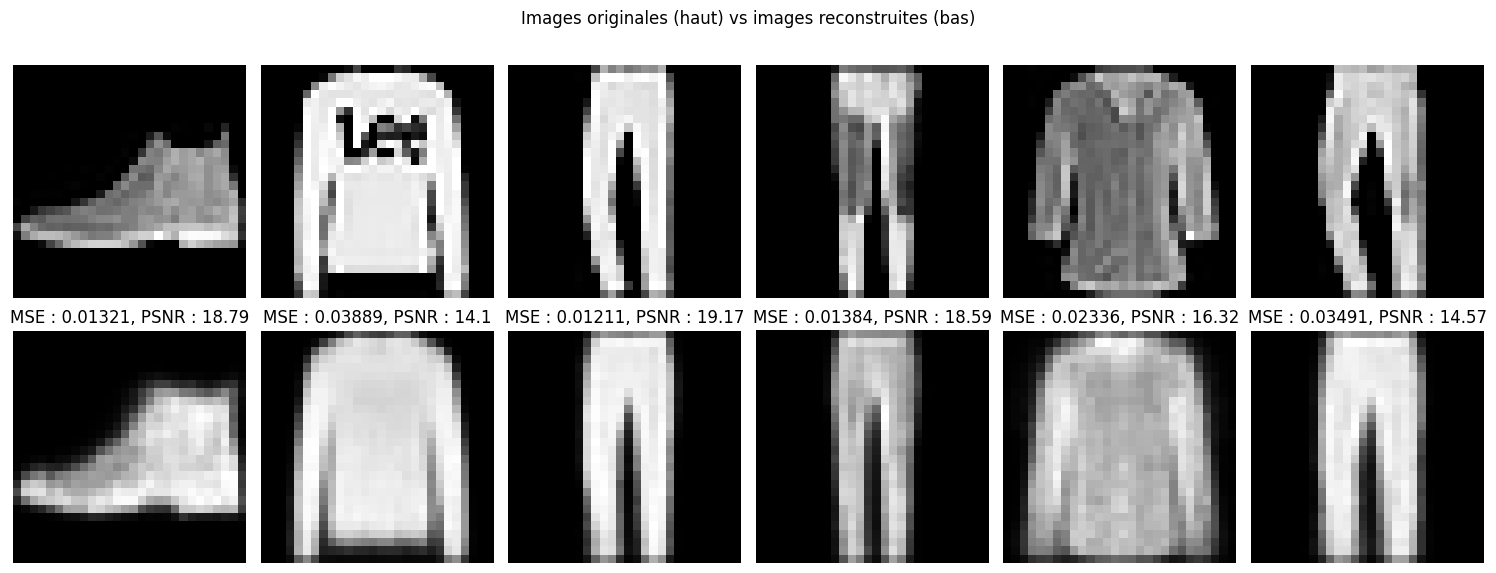

In [111]:
cvae1.eval()

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    labels = labels.to(device)
    recons, _, _ = cvae1(images, labels)

    # Conversion en NumPy pour l'affichage
    images_np = images.cpu().numpy().squeeze(1)
    recons_np = recons.cpu().numpy().squeeze(1)

# Affichage
comparison_images(images_np, "Images originales", recons_np, "Images reconstruites", n_images=6)


In order to assess model-generated images, 3 quantitative metrics are commonly used. Mean Squared Error (MSE) was calculated by summing the squares of the difference between the generated image and a ground truth image pixel-wise. Structural Similarity Index Measure (SSIM) is a metric that evaluates image quality by comparing two images based on structural information, luminance, and contrast [3]. SSIM can be used to compare images of any size while MSE is relative to pixel size. SSIM score ranges from -1 to 1, where 1 indicates identical images. Frechet inception distance (FID) is a metric for quantifying the realism and diversity of images generated. As FID is a distance measure, lower scores are indicative of a better reconstruction of a set of images.

## Création de 5 échantillons de chaque classe 

In [112]:
num_classes = 10
n_samples = 5
zs = torch.randn(n_samples, latent_dim, device=device)
    
all_generated = []

with torch.no_grad():
    for z in zs : 
        z = z.unsqueeze(0).repeat(num_classes, 1)
        labels = torch.arange(num_classes, device = device)
        generated = cvae1.decode(z, labels)  # décodage conditionnel
        all_generated.append(generated.cpu().numpy())
        
all_generated = np.concatenate(all_generated, axis=0)  # (5*10, 1, 28, 28)
all_generated = all_generated.squeeze(1)               #


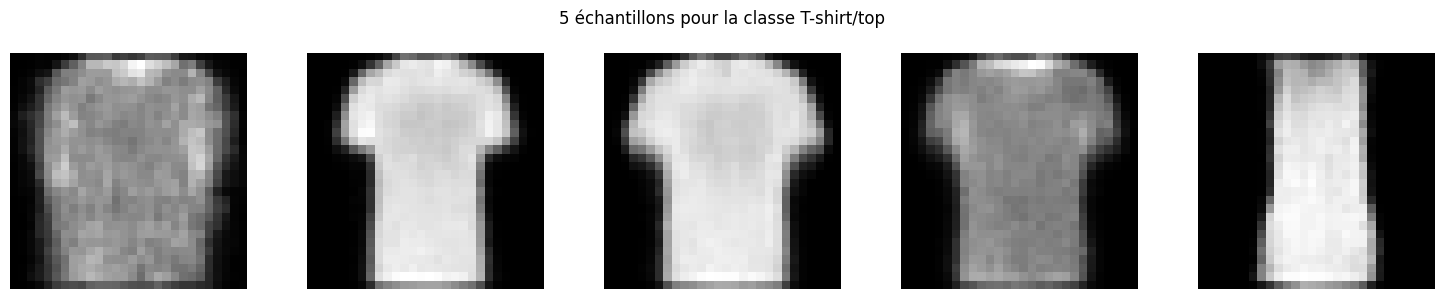

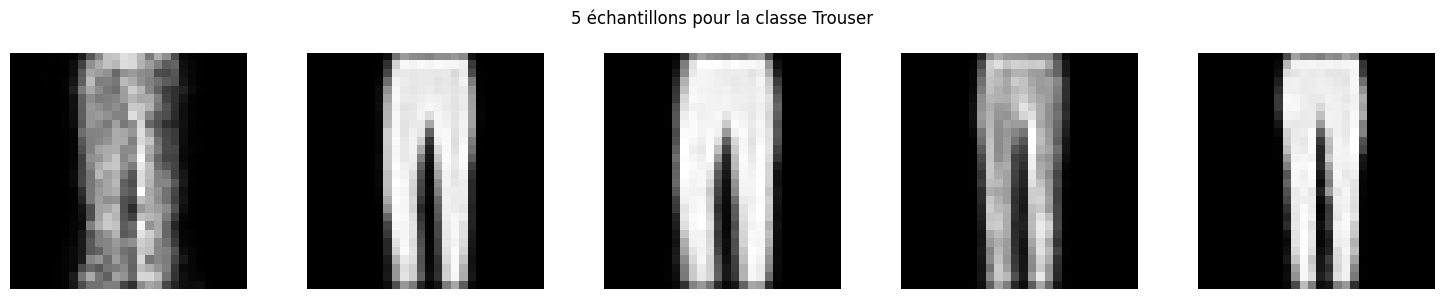

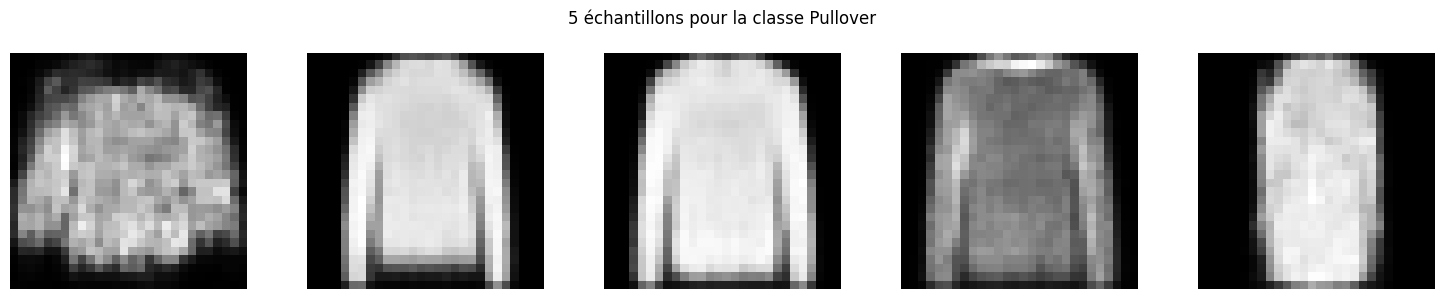

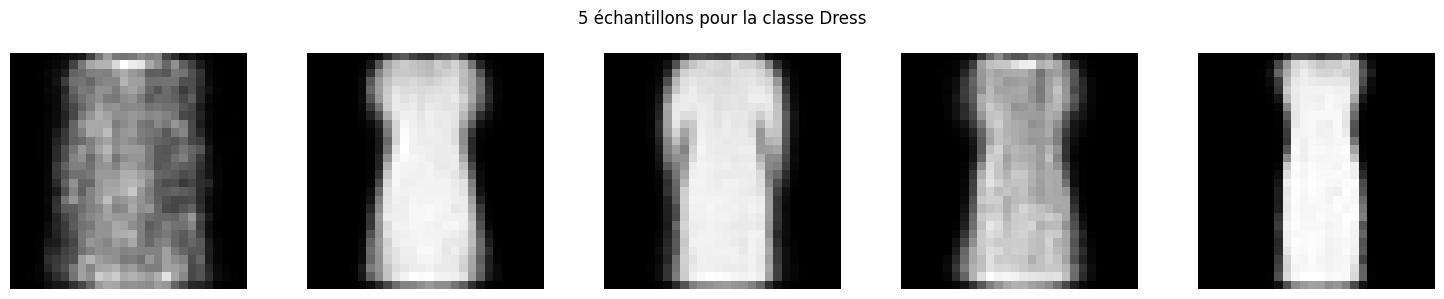

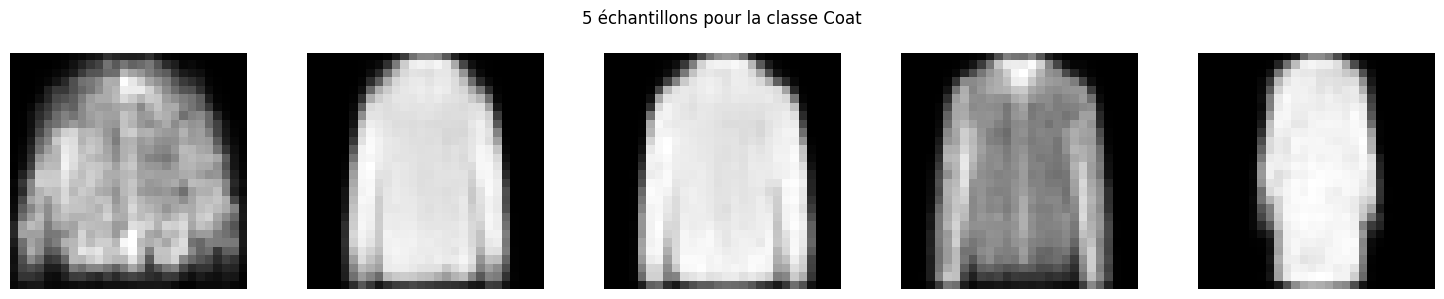

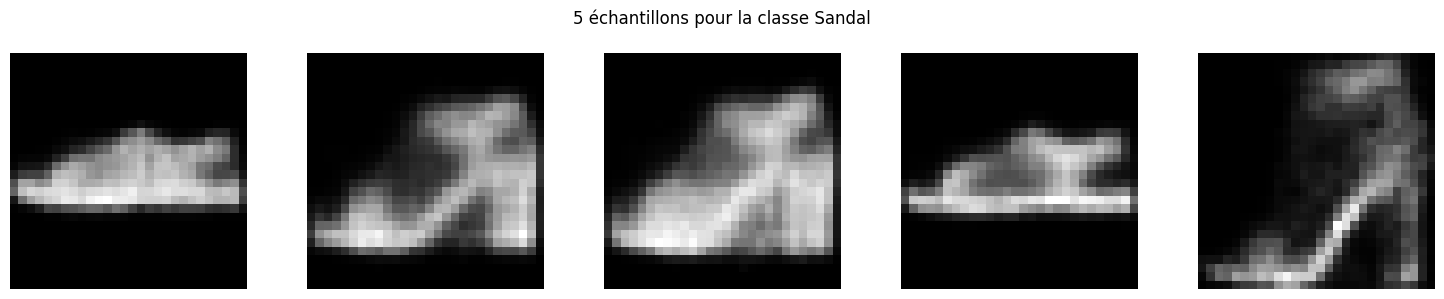

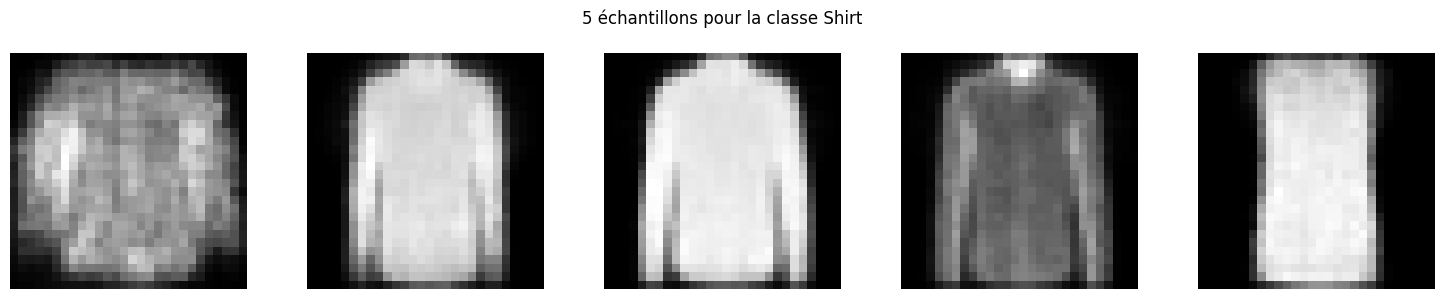

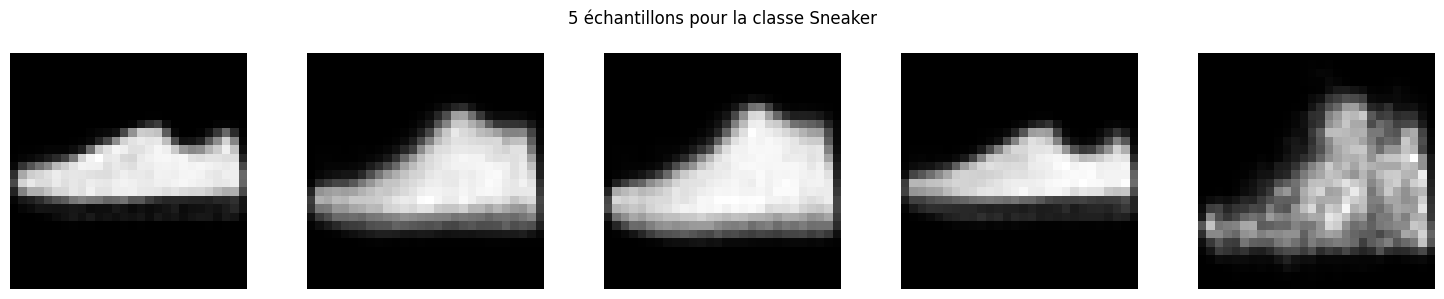

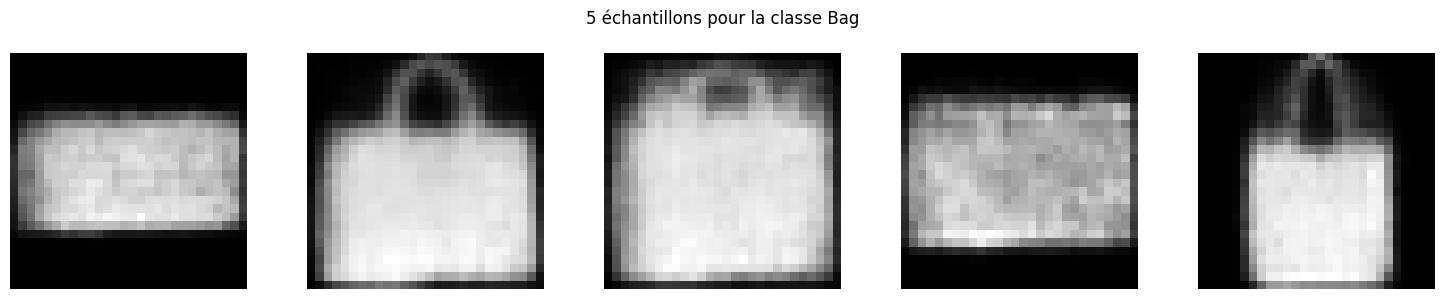

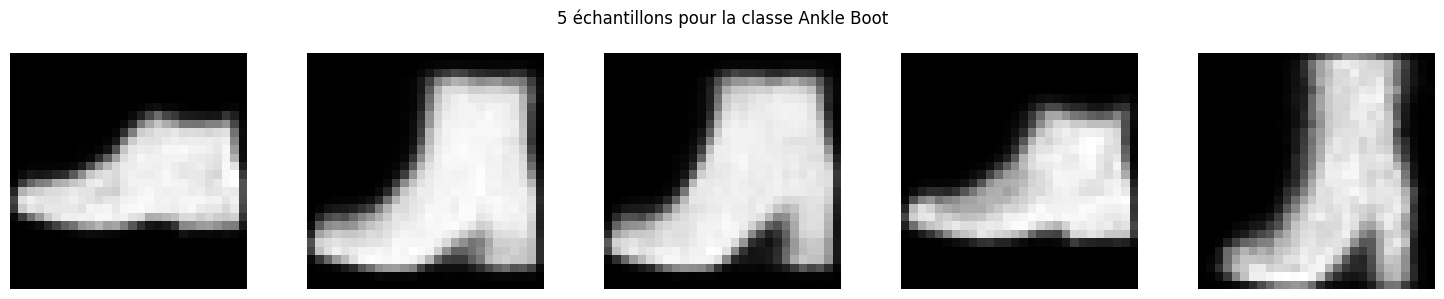

In [113]:
for i in range(num_classes):
    fig, ax = plt.subplots(1, n_samples, figsize=(15, 3))
    for j in range(n_samples):     # colonne = classe
        idx = j * num_classes + i
        ax[j].imshow(all_generated[idx], cmap='gray')
        ax[j].axis('off')
        if j == 0:
            ax[j].set_ylabel(f"Sample {z[i]}", fontsize=12)  # ligne
        fig.suptitle(f"{n_samples} échantillons pour la classe {classes[i]}")
    plt.tight_layout()
    plt.show()

Ici on a pris un les 5 mêmes échantillons de l'espace latent pour reconstruire les images de chaque classes : en effet, on retrouve bien des images semblables (même luminosité par exemple).

Comme la dimension de l'espace latent du modèle est de 2, on peut visualiser l'espace latent

In [132]:
def plot_latent_space(model, zs):
    model.eval()
    latents = []
    labels_list = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)
            mu, _ = model.encode(data, labels)
            latents.append(mu.cpu())
            labels_list.append(labels.cpu())

    latents = torch.cat(latents, dim=0).numpy()
    labels_list = torch.cat(labels_list, dim=0).numpy()

    # Scatter par classe
    for i in range(10):
        idxs = labels_list == i
        plt.scatter(latents[idxs, 0], latents[idxs, 1], label=classes[i], alpha=0.5)

    # Ajouter les z fournis sur le graphe
    for i, z in enumerate(zs):
        z = z.cpu().numpy()
        plt.scatter(z[0], z[1], marker='x', color='red', s=100, label=f'z {i}' if i==0 else None)

    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.title(f"Représentation de l'espace latent du modèle")
    plt.legend()
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


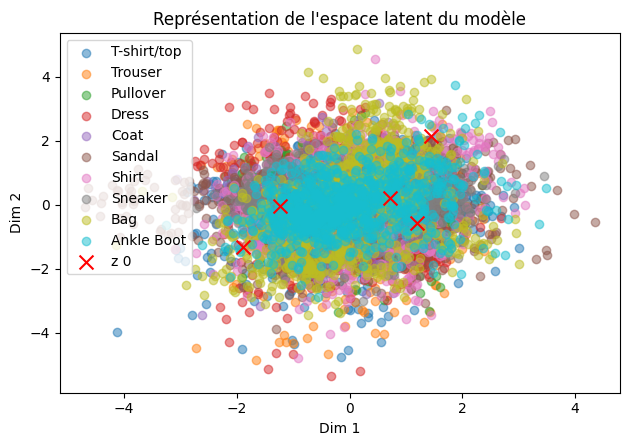

In [133]:
plot_latent_space(cvae1, zs)

# Sources

https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html#cvae


https://towardsdatascience.com/conditional-variational-autoencoders-for-text-to-image-generation-1996da9cefcb/

Entity Embeddings of Categorical Variables (Guo & Berkhahn, 2016)
Deep label embedding learning for classification
Beyond one-hot encoding: Lower dimensional target embedding
Conditional Variational Autoencoders (SID 2025) : mentionne que pour petits espaces de labels on peut utiliser one-hot, mais pour accords de grande cardinalité, des embeddings appris sont préférables pour capturer la structure des conditions